# Movie Recommendation System

In [1]:
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pk
from ast import literal_eval

from jupyterthemes import jtplot
jtplot.style(figsize=(15, 9))

## Data Cleaning

In [2]:
keywords_df = pd.read_csv('../data/popular_10000_movies/keywords_dataframe.csv', index_col='id')
mov_df = pd.read_csv('../data/popular_10000_movies/movies_dataset.csv', index_col='id')

In [3]:
keywords_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
movies_df = mov_df.merge(keywords_df, on='id')
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

In [5]:
movies_df.head()

,genre_ids,original_language,overview,popularity,release_date,title,vote_average,vote_count,genres,keywords
id,,,,,,,,,,
385687,"[28, 80, 53]",en,Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",en,Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
603692,"[28, 53, 80]",en,"With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'id': 242, 'name': 'new york city'}, {'id': ..."
569094,"[28, 12, 16, 878]",en,"After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
502356,"[16, 10751, 12, 14, 35]",en,"While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'id': 282, 'name': 'video game'}, {'id': 690..."


In [6]:
movies_df.shape

(10088, 10)

In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10088 entries, 385687 to 465109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          10088 non-null  object        
 1   original_language  10088 non-null  object        
 2   overview           10085 non-null  object        
 3   popularity         10088 non-null  float64       
 4   release_date       10072 non-null  datetime64[ns]
 5   title              10088 non-null  object        
 6   vote_average       10088 non-null  float64       
 7   vote_count         10088 non-null  int64         
 8   genres             10070 non-null  object        
 9   keywords           10088 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 630.5+ KB


In [8]:
movies_df['original_language'].value_counts()

en    10088
Name: original_language, dtype: int64

In [9]:
movies_df.drop('original_language', axis=1, inplace=True)

In [10]:
movies_df.isnull().sum()

genre_ids        0
overview         3
popularity       0
release_date    16
title            0
vote_average     0
vote_count       0
genres          18
keywords         0
dtype: int64

In [11]:
movies_df.drop(movies_df[movies_df['keywords']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['vote_average']==0].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['vote_count']<100].index, axis=0, inplace=True)
movies_df.dropna(axis=0, inplace=True)

In [12]:
movies_df.isnull().sum()

genre_ids       0
overview        0
popularity      0
release_date    0
title           0
vote_average    0
vote_count      0
genres          0
keywords        0
dtype: int64

In [13]:
movies_df[movies_df.duplicated()].shape

(95, 9)

In [14]:
movies_df.drop_duplicates(inplace=True)

In [15]:
movies_df[movies_df.duplicated()].shape

(0, 9)

In [16]:
# Delete movies with useless keywords
idxs = [184, 476, 1094, 2022, 3655, 4071, 4485, 5432, 5535, 6655, 6885, 7481, 7504]
movies_df.drop(movies_df.iloc[idxs].index, axis=0, inplace=True)

In [17]:
movies_df.shape

(8393, 9)

## EDA

In [18]:
movies_df.groupby('genres').mean().sort_values(['vote_average'], ascending=False).head(10)

,popularity,vote_average,vote_count
genres,,,
"Fantasy, Drama, Crime",69.123,8.5,15537.0
"Drama, Thriller, Comedy",73.566,8.4,26647.0
"TV Movie, Animation, Science Fiction, Action, Adventure, Comedy, Drama, Fantasy, Music",24.249,8.3,754.0
"Family, Animation, Drama",97.326,8.3,16649.0
"Animation, Family, Fantasy, Adventure, Comedy",502.086,8.3,5832.0
"Horror, Music",12.705,8.2,581.0
"Family, Animation, Music",15.704,8.2,143.0
"Family, Animation, Fantasy, Music, Comedy, Adventure",106.932,8.2,17338.0
"Animation, Fantasy, Drama, Music",89.246,8.2,2327.0


In [19]:
movies_df.groupby('genres').mean().sort_values(['vote_average'], ascending=True).head(10)

,popularity,vote_average,vote_count
genres,,,
"Action, Adventure, Fantasy, Science Fiction, Thriller",33.077,2.9,1867.0
"Science Fiction, Horror, Action, Thriller",13.295,2.9,117.0
"Fantasy, Science Fiction, Family, TV Movie",15.379,3.3,408.0
"Horror, Action, Comedy, Science Fiction, Adventure",11.146,3.9,1436.0
"Science Fiction, Comedy, Family",11.359,4.0,321.0
"Adventure, Thriller, Horror",18.743,4.1,885.0
"Crime, Fantasy, Horror, Thriller",16.582,4.2,3696.0
"Mystery, Adventure, Comedy, Crime",15.003,4.3,741.0
"Action, Science Fiction, Adventure, Comedy",35.667,4.3,4533.0


In [20]:
movies_df.groupby('genres').count().sort_values(['vote_average'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,keywords
genres,,,,,,,,
Drama,403,403,403,403,403,403,403,403
Comedy,345,345,345,345,345,345,345,345
"Comedy, Romance",222,222,222,222,222,222,222,222
"Drama, Romance",214,214,214,214,214,214,214,214
"Horror, Thriller",170,170,170,170,170,170,170,170
"Comedy, Drama",169,169,169,169,169,169,169,169
Horror,140,140,140,140,140,140,140,140
"Comedy, Drama, Romance",137,137,137,137,137,137,137,137
"Drama, History",100,100,100,100,100,100,100,100


In [21]:
movies_df.groupby('genres').count().sort_values(['vote_average'], ascending=False).tail(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,keywords
genres,,,,,,,,
"Adventure, Drama, Science Fiction, Fantasy",1,1,1,1,1,1,1,1
"Adventure, Family, Animation, Action, Comedy",1,1,1,1,1,1,1,1
"Adventure, Drama, Thriller, History",1,1,1,1,1,1,1,1
"Drama, Mystery, Western",1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, TV Movie",1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Horror",1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, History",1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Fantasy",1,1,1,1,1,1,1,1
"Adventure, Family, Action, Fantasy",1,1,1,1,1,1,1,1


In [22]:
movies_df.sort_values(['vote_average'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,keywords
id,,,,,,,,,
238,"[18, 80]","Spanning the years 1945 to 1955, a chronicle o...",120.966,1972-03-14,The Godfather,8.7,18141,"Drama, Crime","[{'id': 131, 'name': 'italy'}, {'id': 697, 'na..."
373558,"[10402, 99]","Filmed in front of 76,000 fans at the ANZ Stad...",15.562,2015-12-20,Taylor Swift: The 1989 World Tour - Live,8.7,119,"Music, Documentary","[{'id': 1740, 'name': 'pop culture'}, {'id': 2..."
278,"[18, 80]",Framed in the 1940s for the double murder of h...,107.982,1994-09-23,The Shawshank Redemption,8.7,24021,"Drama, Crime","[{'id': 378, 'name': 'prison'}, {'id': 417, 'n..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
424,"[18, 36, 10752]",The true story of how businessman Oskar Schind...,60.506,1993-12-15,Schindler's List,8.6,14198,"Drama, History, War","[{'id': 818, 'name': 'based on novel or book'}..."
240,"[18, 80]",In the continuing saga of the Corleone crime f...,68.191,1974-12-20,The Godfather Part II,8.6,10949,"Drama, Crime","[{'id': 131, 'name': 'italy'}, {'id': 700, 'na..."
664280,[99],The story of life on our planet by the man who...,12.926,2020-09-28,David Attenborough: A Life on Our Planet,8.5,284,Documentary,"[{'id': 2210, 'name': 'climate change'}, {'id'..."
122,"[12, 14, 28]",Aragorn is revealed as the heir to the ancient...,86.748,2003-12-01,The Lord of the Rings: The Return of the King,8.5,21759,"Adventure, Fantasy, Action","[{'id': 603, 'name': 'elves'}, {'id': 604, 'na..."
497,"[14, 18, 80]",A supernatural tale set on death row in a Sout...,69.123,1999-12-10,The Green Mile,8.5,15537,"Fantasy, Drama, Crime","[{'id': 531, 'name': 'southern usa'}, {'id': 7..."


In [23]:
movies_df.sort_values(['vote_average'], ascending=True).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,keywords
id,,,,,,,,,
19157,[35],A struggling young comedian takes a menial job...,11.868,1989-05-11,Going Overboard,2.3,112,Comedy,"[{'id': 407, 'name': 'dictator'}, {'id': 2398,..."
10838,"[27, 878]","In the year 3000, the deep space salvage ship ...",11.360,2004-08-09,Dracula 3000,2.7,114,"Horror, Science Fiction","[{'id': 1826, 'name': 'space marine'}, {'id': ..."
14164,"[28, 12, 14, 878, 53]","On his 18th birthday, Goku receives a mystical...",33.077,2009-03-12,Dragonball Evolution,2.9,1867,"Action, Adventure, Fantasy, Science Fiction, T...","[{'id': 3436, 'name': 'karate'}, {'id': 9715, ..."
11525,"[878, 27, 28, 53]",Jobe is resuscitated by Jonathan Walker. He wa...,13.295,1996-01-12,Lawnmower Man 2: Beyond Cyberspace,2.9,117,"Science Fiction, Horror, Action, Thriller","[{'id': 1576, 'name': 'technology'}, {'id': 21..."
5491,"[28, 12, 35, 878]","In the year 3000, man is no match for the Psyc...",12.444,2000-05-12,Battlefield Earth,3.2,725,"Action, Adventure, Comedy, Science Fiction","[{'id': 818, 'name': 'based on novel or book'}..."
11059,"[27, 28, 53]","Set on an island off the coast, a techno rave ...",11.457,2003-04-11,House of the Dead,3.2,339,"Horror, Action, Thriller","[{'id': 2041, 'name': 'island'}, {'id': 3221, ..."
74849,"[14, 878, 10751, 10770]",Luke Skywalker and Han Solo battle evil Imperi...,15.379,1978-12-01,The Star Wars Holiday Special,3.3,408,"Fantasy, Science Fiction, Family, TV Movie","[{'id': 65, 'name': 'holiday'}, {'id': 3741, '..."
12142,"[28, 14, 27]",Edward Carnby is a private investigator specia...,13.641,2005-01-28,Alone in the Dark,3.3,527,"Action, Fantasy, Horror","[{'id': 703, 'name': 'detective'}, {'id': 1299..."
135812,[27],When Englishman Jonathan Harker visits the exo...,12.126,2012-11-09,Dracula 3D,3.3,192,Horror,"[{'id': 3133, 'name': 'vampire'}, {'id': 15032..."


In [24]:
movies_df.sort_values(['popularity'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,keywords
id,,,,,,,,,
385687,"[28, 80, 53]",Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
603692,"[28, 53, 80]","With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'id': 242, 'name': 'new york city'}, {'id': ..."
502356,"[16, 10751, 12, 14, 35]","While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'id': 282, 'name': 'video game'}, {'id': 690..."
667538,"[28, 12, 878]",When a new threat capable of destroying the en...,1423.735,2023-06-06,Transformers: Rise of the Beasts,7.1,469,"Action, Adventure, Science Fiction","[{'id': 5967, 'name': 'peru'}, {'id': 9951, 'n..."
976573,"[16, 35, 10751, 14, 10749]","In a city where fire, water, land and air resi...",1224.270,2023-06-14,Elemental,7.4,200,"Animation, Comedy, Family, Fantasy, Romance","[{'id': 657, 'name': 'fire'}, {'id': 10159, 'n..."
298618,"[878, 28, 12]",When his attempt to save his family inadverten...,965.786,2023-06-13,The Flash,6.7,639,"Science Fiction, Action, Adventure","[{'id': 1308, 'name': 'secret identity'}, {'id..."
447365,"[28, 878, 12]","Peter Quill, still reeling from the loss of Ga...",960.044,2023-05-03,Guardians of the Galaxy Vol. 3,8.0,2111,"Action, Science Fiction, Adventure","[{'id': 1701, 'name': 'hero'}, {'id': 9663, 'n..."


### Visualization

Text(0, 0.5, 'Popular Genres')

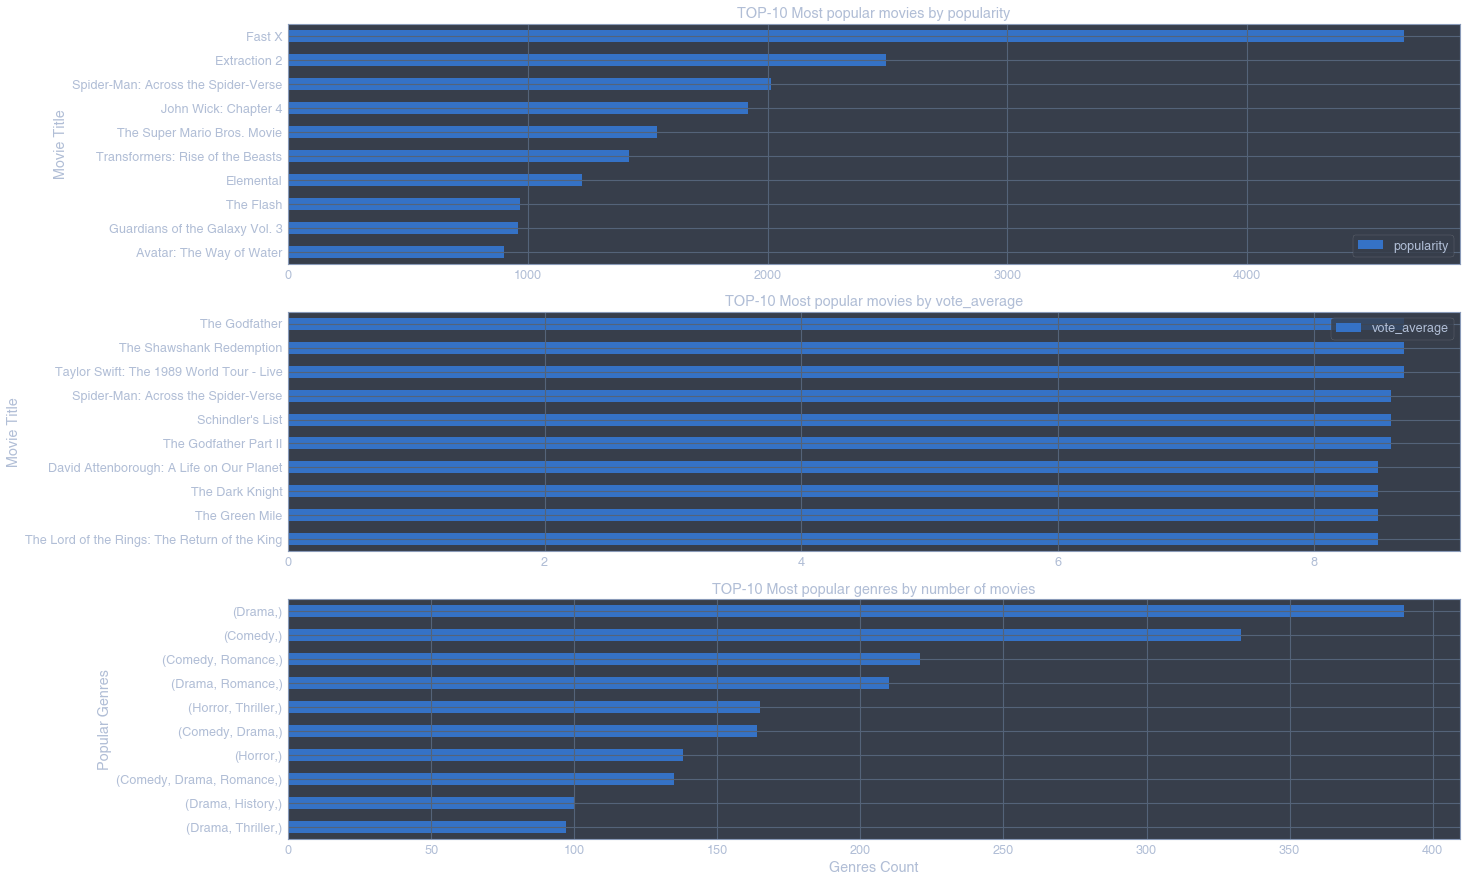

In [49]:
movies_by_popularity = movies_df.sort_values(['popularity'], ascending=False)\
                                .head(10)[['title', 'popularity']]\
                                .reset_index(drop=True)
movies_by_popularity.set_index('title', inplace=True)

movies_by_vote_average = movies_df.sort_values(['vote_average'], ascending=False)\
                                  .head(10)[['title', 'vote_average']]\
                                  .reset_index(drop=True)
movies_by_vote_average.set_index('title', inplace=True)

genres_by_date = movies_df.groupby('release_date')['genres']\
                          .value_counts()\
                          .to_frame()\
                          .rename(columns={'genres': 'genres_count'})\
                          .reset_index()

fig, ax = plt.subplots(3, 1, figsize=(21, 15))

movies_by_popularity.plot(kind='barh', ax=ax[0]).invert_yaxis()
ax[0].set_title('TOP-10 Most popular movies by popularity')
ax[0].set_ylabel('Movie Title')

movies_by_vote_average.plot(kind='barh', ax=ax[1]).invert_yaxis()
ax[1].set_title('TOP-10 Most popular movies by vote_average')
ax[1].set_ylabel('Movie Title')

genres_by_date.value_counts(['genres']).head(10).plot(kind='barh', x='genres', y='genres_count', ax=ax[2]).invert_yaxis()
ax[2].set_title('TOP-10 Most popular genres by number of movies')
ax[2].set_xlabel('Genres Count')
ax[2].set_ylabel('Popular Genres')

Text(0, 0.5, 'Vote Count')

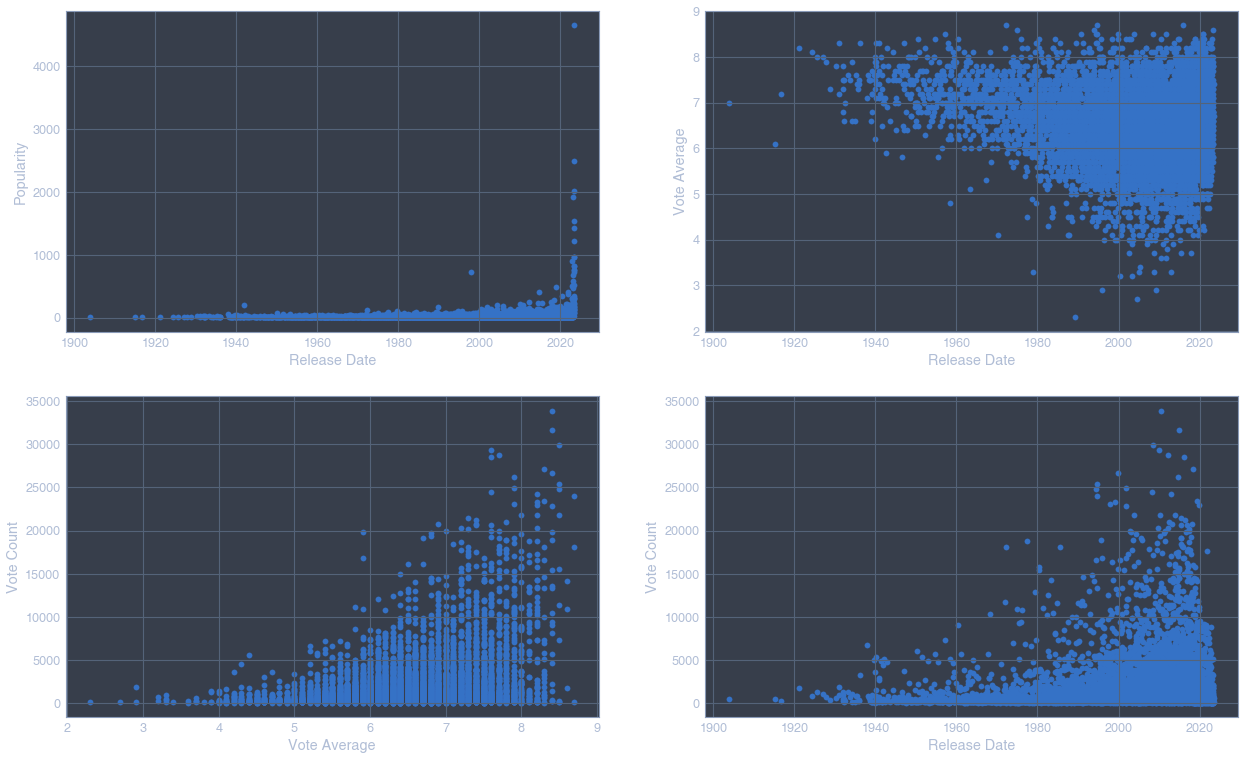

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(21, 13))

axs[0, 0].scatter(movies_df['release_date'], movies_df['popularity'])
axs[0, 0].set_xlabel('Release Date')
axs[0, 0].set_ylabel('Popularity')

axs[0, 1].scatter(movies_df['release_date'], movies_df['vote_average'])
axs[0, 1].set_xlabel('Release Date')
axs[0, 1].set_ylabel('Vote Average')

axs[1, 0].scatter(movies_df['vote_average'], movies_df['vote_count'])
axs[1, 0].set_xlabel('Vote Average')
axs[1, 0].set_ylabel('Vote Count')

axs[1, 1].scatter(movies_df['release_date'], movies_df['vote_count'])
axs[1, 1].set_xlabel('Release Date')
axs[1, 1].set_ylabel('Vote Count')

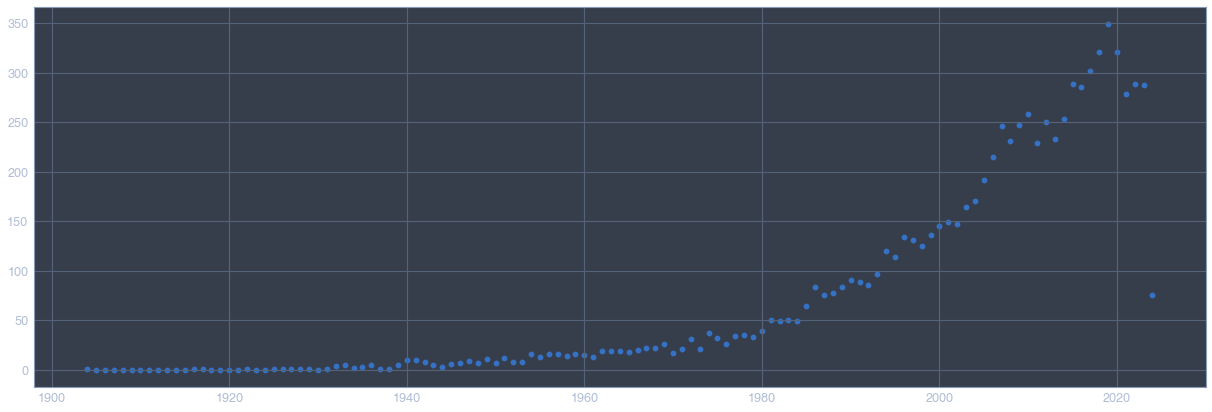

In [51]:
release_date_index = movies_df.copy()
release_date_index.reset_index(inplace=True)
release_date_index.set_index(['release_date'], inplace=True)

movies_by_years = release_date_index.resample('1Y').count()['id']

fig, ax = plt.subplots(figsize=(21, 7))
ax.scatter(movies_by_years.index, movies_by_years)

## Prepare Data

### Genres

Text(0.5, 1.0, 'Correlation')

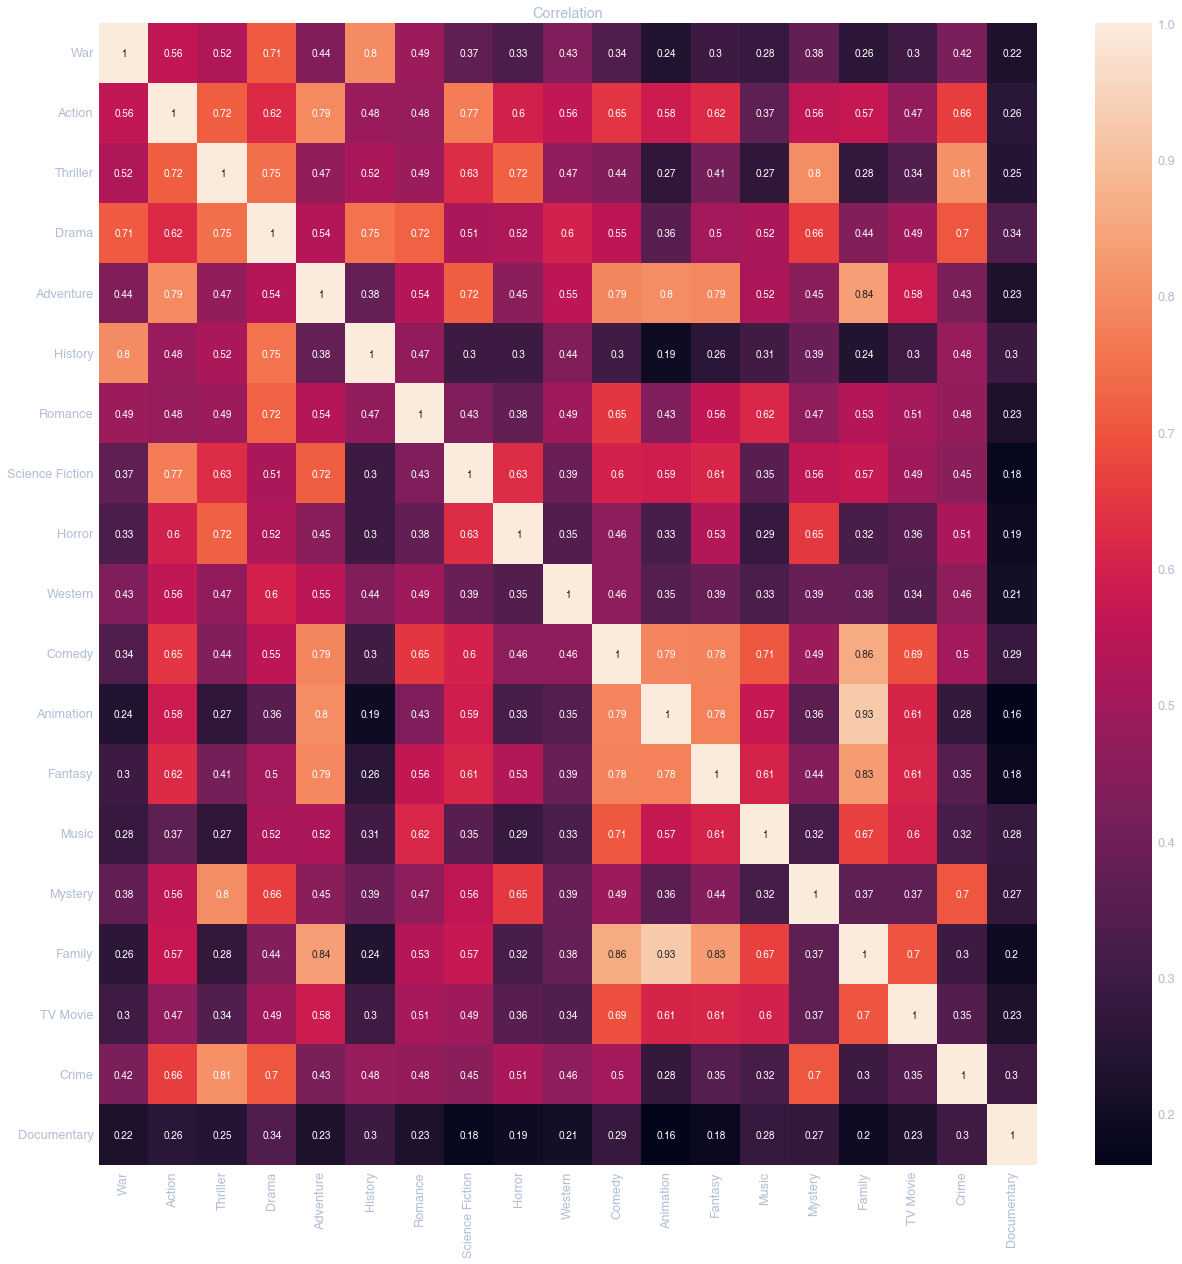

In [18]:
genres_list = list(movies_df['genres'].unique())
gl = []
for g in genres_list:
    gl.extend(g.split(', '))
    
GENRES = list(set(gl))

vector_GENRES = pd.DataFrame(index=movies_df.index, columns=GENRES)
genres = movies_df['genres'].to_frame()

for i in range(genres.shape[0]):
    df = np.full(len(GENRES), 0)
    
    for j in str(genres['genres'].iloc[i]).split(', '):
        df[GENRES.index(j)] = 1

    vector_GENRES.iloc[i] = df
    
genres_counter = {}
l = []
for g in GENRES:
    for gs in genres_list:
        if g in gs.split(', '):
            l.extend(gs.split(', '))
    genres_counter[g] = dict(Counter(l))
    l = []

genres_df = pd.DataFrame(data=genres_counter).fillna(0).astype(int)
genres_cs = pd.DataFrame(data=cosine_similarity(genres_df), index=genres_df.index, columns=genres_df.index)

plt.figure(figsize=(21, 21))
sns.heatmap(genres_cs, annot=True)
plt.title('Correlation')

### Helpers

In [19]:
# flat_list = lambda list_of_the_lists: [elm for list_from_list in list_of_the_lists for elm in list_from_list]
def flat_list(list_of_the_lists: list)->list:
    return [e for list_from_list in list_of_the_lists for e in list_from_list]


def get_vectors(df: pd.DataFrame, unique_list: list, vector_GENRES: pd.DataFrame)->pd.DataFrame:
    df_vectors = pd.DataFrame(0, index=unique_list, columns=vector_GENRES.columns)
    df_vectors.head()
    
    for _id in df.index:
        row = df.loc[_id][0]
        genres_vector = vector_GENRES.loc[_id].to_list()
        for item in row:
            df_vectors.loc[item] += genres_vector
    
    return df_vectors


def sum_of_vectors(df: pd.DataFrame, df_vectors: pd.DataFrame, unique_list: list)->pd.DataFrame:
    df_vectors_sum = pd.DataFrame(index=df.index, columns=unique_list)
    
    def get_sum(row):
        _ids = df_vectors.loc[df.loc[row.name][0]]
        return _ids.sum()

    df_vectors_sum = df.apply(get_sum, axis=1)
    
    return df_vectors_sum


def clean_data(feature_name: str)->pd.DataFrame:
    list_of_the_dicts = []
    for w in movies_df[feature_name].to_list():
        list_of_the_dicts.append(literal_eval(w))
    
    list_of_the_lists = [[k_d['name'] for k_d in k_l] for k_l in list_of_the_dicts]
    
    feature_df = pd.DataFrame(index=movies_df.index,
                              columns=[feature_name+'_list'],
                              data=np.array(list_of_the_lists, dtype=object))
    unique_features = list(set(flat_list(list_of_the_lists)))
    
    return feature_df, unique_features

def get_sum_of_vectors(feature_name: str)->pd.DataFrame:
    feature_df, unique_features = clean_data(feature_name)
    feature_vectors = get_vectors(feature_df, unique_features, vector_GENRES)
    feature_sum_vectors = sum_of_vectors(feature_df, feature_vectors, GENRES)
    
    return feature_sum_vectors
    

### Get Keywords Sum of Vectors

In [21]:
keywords_sum_vectors = get_sum_of_vectors('keywords')
keywords_sum_vectors.head(10)

,War,Drama,Family,Horror,Fantasy,Science Fiction,Documentary,Crime,Mystery,Thriller,Adventure,Animation,Comedy,TV Movie,Western,Romance,Music,Action,History
id,,,,,,,,,,,,,,,,,,,
385687,11,237,175,210,114,134,2,169,72,331,230,97,291,16,24,80,13,370,15
697843,16,79,98,140,74,114,1,73,42,187,177,63,165,12,2,26,8,251,5
603692,15,457,202,206,188,234,5,422,152,544,378,137,520,15,8,169,36,652,24
569094,10,138,232,211,295,501,3,161,92,266,555,313,359,29,8,46,15,830,1
502356,11,167,253,85,177,163,4,80,44,132,338,197,503,3,11,100,38,307,18
667538,8,169,207,89,109,313,4,64,50,149,263,150,377,9,7,78,39,284,16
976573,0,21,14,15,17,9,1,8,6,21,11,17,16,0,1,7,0,15,3
536437,0,4,0,3,1,2,0,1,5,9,0,0,0,1,0,0,0,2,0
298618,15,106,192,86,268,417,3,124,71,165,516,274,333,13,12,39,12,744,12


## I Want To Watch Something Like...

In [24]:
class Vectors_CS:
    __VECTORS = {
        'keywords': keywords_sum_vectors,
    }
    
    def __init__(self, like):
        self._like = like
        self._similar = movies_df[~movies_df['title'].isin(self._like['title'])]
        self.threshold = 0.9
        self._cosine_similarity = self.calc_cosine_similarity()
        
    def calc_cosine_similarity(self)->pd.DataFrame:
        like_vectors = self.__VECTORS['keywords'].loc[self._like.index]
        similar_vectors = self.__VECTORS['keywords'].loc[self._similar.index]
        
        cs = cosine_similarity(
            like_vectors,
            similar_vectors
        )
        return self.convert_to_DF(cs.transpose())

    def convert_to_DF(self, data)->pd.DataFrame:
        df = pd.DataFrame(
            index=self._similar.index,
            columns=self._like.index,
            data=data
        )
        return df
    
    def show_similar(self)->pd.DataFrame:
        recommendation = self._cosine_similarity[self._cosine_similarity[self._like.index]
                                                > self.threshold].dropna(axis=0)
        recommendation['sum'] = recommendation.sum(axis=1)
        recommendation.sort_values('sum', ascending=False, inplace=True)
        return recommendation.index

    

In [25]:
class IWantToWatchSomethingLike:
    def __init__(self, i_like:list):
        self.like_df = movies_df[movies_df['title'].isin(i_like)]
        if self.like_df.shape[0]:
            self.vectors = Vectors_CS(self.like_df)
    
    def show_recommendation(self, amount=10)->pd.DataFrame:
        return movies_df.loc[self.vectors.show_similar()].head(amount)
        
    def show_me_what_i_like(self)->pd.DataFrame:
        return self.like_df
    


In [26]:
IWantToWatchSomethingLike(['Alien', 'Starship Troopers']).show_recommendation()

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,keywords
id,,,,,,,,,
644,"[18, 878, 12]","David, a robotic boy—the first of his kind pro...",28.966,2001-06-29,A.I. Artificial Intelligence,7.0,5613,"Drama, Science Fiction, Adventure","[{'id': 310, 'name': 'artificial intelligence'..."
193,"[878, 28, 12, 53]",Captain Jean-Luc Picard and the crew of the En...,12.682,1994-11-18,Star Trek: Generations,6.5,1154,"Science Fiction, Action, Adventure, Thriller","[{'id': 697, 'name': 'loss of loved one'}, {'i..."
63,"[878, 53, 9648]","In the year 2035, convict James Cole reluctant...",34.378,1995-12-29,Twelve Monkeys,7.6,7521,"Science Fiction, Thriller, Mystery","[{'id': 222, 'name': 'schizophrenia'}, {'id': ..."
329865,"[18, 878, 9648]",Taking place after alien crafts land around th...,51.901,2016-11-10,Arrival,7.6,16277,"Drama, Science Fiction, Mystery","[{'id': 1612, 'name': 'spacecraft'}, {'id': 36..."
10200,"[18, 878, 53]",A representative of an alien race that went th...,32.306,2008-12-10,The Day the Earth Stood Still,5.6,3063,"Drama, Science Fiction, Thriller","[{'id': 1603, 'name': 'extraterrestrial techno..."
17654,[878],"Thirty years ago, aliens arrive on Earth. Not ...",32.534,2009-08-05,District 9,7.4,8573,Science Fiction,"[{'id': 100, 'name': 'slum'}, {'id': 542, 'nam..."
828,"[18, 878]",An alien and a robot land on Earth after World...,16.288,1951-09-28,The Day the Earth Stood Still,7.5,950,"Drama, Science Fiction","[{'id': 1612, 'name': 'spacecraft'}, {'id': 32..."
2362,"[12, 878, 37]",A robot malfunction creates havoc and terror f...,16.956,1973-08-15,Westworld,6.7,1122,"Adventure, Science Fiction, Western","[{'id': 312, 'name': 'man vs machine'}, {'id':..."
157336,"[12, 18, 878]",The adventures of a group of explorers who mak...,130.980,2014-11-05,Interstellar,8.4,31699,"Adventure, Drama, Science Fiction","[{'id': 310, 'name': 'artificial intelligence'..."


In [27]:
IWantToWatchSomethingLike(['Dracula']).show_recommendation()

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,keywords
id,,,,,,,,,
10727,"[53, 27]",A vengeful spirit has taken the form of the To...,16.688,2003-01-24,Darkness Falls,5.5,509,"Thriller, Horror","[{'id': 616, 'name': 'witch'}, {'id': 697, 'na..."
6114,"[10749, 27]",When Dracula leaves the captive Jonathan Harke...,32.956,1992-11-13,Bram Stoker's Dracula,7.5,4517,"Romance, Horror","[{'id': 212, 'name': 'london, england'}, {'id'..."
288158,"[53, 27, 18]",40 years after the first haunting at Eel Marsh...,17.062,2014-12-30,The Woman in Black 2: Angel of Death,5.3,947,"Thriller, Horror, Drama","[{'id': 818, 'name': 'based on novel or book'}..."
501170,"[27, 53, 14]",Still irrevocably scarred by the trauma he end...,40.327,2019-10-30,Doctor Sleep,7.2,3843,"Horror, Thriller, Fantasy","[{'id': 818, 'name': 'based on novel or book'}..."
7978,"[27, 36, 18, 53]","Lawrence Talbot, an American man on a visit to...",23.749,2010-02-10,The Wolfman,5.8,1798,"Horror, History, Drama, Thriller","[{'id': 970, 'name': 'parent child relationshi..."
814,"[27, 35]",Two American tourists in England are attacked ...,30.046,1981-08-21,An American Werewolf in London,7.4,2057,"Horror, Comedy","[{'id': 212, 'name': 'london, england'}, {'id'..."
10836,"[14, 27, 53]",A boating accident off the coast of Spain send...,12.209,2001-10-12,Dagon,6.2,328,"Fantasy, Horror, Thriller","[{'id': 236, 'name': 'suicide'}, {'id': 380, '..."
9030,"[18, 27, 53]",Violinist Sydney Wells was accidentally blinde...,15.106,2008-02-01,The Eye,5.8,933,"Drama, Horror, Thriller","[{'id': 380, 'name': 'sibling relationship'}, ..."
10320,"[18, 27, 53]",Rachel Keller must prevent evil Samara from ta...,21.628,2005-03-17,The Ring Two,5.7,2060,"Drama, Horror, Thriller","[{'id': 745, 'name': 'nun'}, {'id': 818, 'name..."
